## References
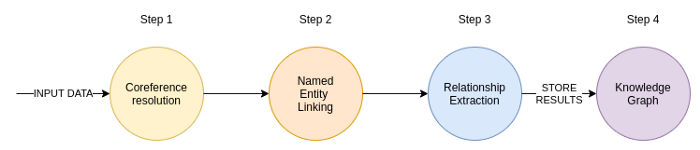

source: https://towardsdatascience.com/from-text-to-knowledge-the-information-extraction-pipeline-b65e7e30273e

In [2]:
import pandas as pd
df = pd.read_csv('./data/users_subset.csv').reset_index()
df.head()

,index,userid,text,propagator
0,0,1258981724,F***ing NARCISSIST!!!! . Thank you for making ...,0
1,1,235395935,: Denmark offers to buy America from Russia ....,0
2,2,867343717,: JUST IN: State Department confirms that Pre...,0
3,3,760470116328964096,": . : . : . : Birha ki rein kate na pahaad, S...",0
4,4,273970953,: E. Jean Carroll reveals that she sexually h...,1


## 1. Coreference Resolution (OPTIONAL)
- Definition: In short, coreference is the fact that two or more expressions in a text – like pronouns or nouns – link to the same person or thing. 
- Source: https://medium.com/huggingface/state-of-the-art-neural-coreference-resolution-for-chatbots-3302365dcf30
- Software: https://github.com/huggingface/neuralcoref
- A demo: https://huggingface.co/coref/?text=Ugur%20and%20Saed%20are%20working%20on%20a%20project.%20That%20project%20will%20classify%20dogs%20and%20cats%20of%20a%20large%20dataset.%20They%20are%20going%20to%20publish%20the%20results%20of%20that%20research%20soon.


In [ ]:
#if error 'en' not found:
# python -m spacy link en_core_web_sm en --force
# python -m spacy download en
# python -m spacy download en_core_web_sm
# Load your usual SpaCy model (one of SpaCy English models)

import spacy

nlp = spacy.load("en_core_web_sm")

import neuralcoref
coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name='neuralcoref')

# You're done. You can now use NeuralCoref the same way you usually manipulate a SpaCy document and it's annotations.
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
print(doc)



## 2. Named Entity Linking

### Load env variables

In [1]:
from dotenv import load_dotenv
from pathlib import Path
import os

dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
WIKIFIER_USERKEY = os.getenv('WIKIFIER_USERKEY')


rvtvyinucctfzzpotzefhouumbssll


### Setting wikifier options for Annotations

In [19]:
#Your user name, saber, has been registered successfully.
#Your user key is: jsxxqgozhvdoxtgmbpiudizxygikgb

#todo: currently, limit is the first 20000 characters, split the request into multiple requests to get info of all
#todo: line by line writing, then get data of all users
#todo: try other thresholds (-1 disables)
import urllib.parse, urllib.request, json

def CallWikifier(text, lang="en", threshold=0.9):
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", WIKIFIER_USERKEY),
        ("pageRankSqThreshold", "%g" % threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "true"), ("maxMentionEntropy", "3"), ("partsOfSpeech", "true")
        ])
    url = "http://wikifier.ijs.si/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    return response["annotations"]

### Calling wikifer annotations API and saving data

In [20]:
wikified_rows = []
for i in df.index:
    print(i, df.loc[i]['userid'])
    text = df.loc[i]['text'][:20000]
    userid = df.loc[i]['userid']
    try:
        annotations = CallWikifier(text)
        for a in annotations:
            wikified_row = {'userid':userid, 'title': a['title'], 'url':a['url'], 'pageRank':a["pageRank"], 'lang':a["lang"], 'wikiDataItemId': a["wikiDataItemId"],'dbPediaIri':a["dbPediaIri"], 'propagator':df.loc[i]['propagator']}
            wikified_rows.append(wikified_row)
    except Exception as e:
        print(e)
        print("User Error:",userid,"Index:",i)

wikified_df =pd.DataFrame.from_records(wikified_rows)
wikified_df.to_csv('wikified-temp.csv')
print("done")

0 1258981724
<urlopen error [Errno 111] Connection refused>
User Error: 1258981724 Index: 0
1 235395935
<urlopen error [Errno 111] Connection refused>
User Error: 235395935 Index: 1
done


## 3. Relationship Extraction

### Setting wikifier options for Neighbors

- The vertex _t_ representing the page whose title is specified by the value of the title parameter.
- Any vertex _u_ such that a directed path, at most nPredLevels edges long, exists from _u_ to _t_.
- Any vertex _v_ such that a directed path, at most nSuccLevels edges long, exists from _t_ to _v_.


The result will be a JSON object of the following form:

`{
    "nVertices": 123, "nEdges": 1234,
    "titles": [...],
    "successors": [[...], [...], ...]
}`
- vertices are numbered in an arbitrary order from `0` to `nVertices − 1`
- `titles[k]` gives the title of the Wikipedia page that corresponds to vertex `k`
- `successors[k]` is an array containing the numbers of the successors of this vertex

In [23]:
def NeighGraph(lang, title, nPredLevels, nSuccLevels):
    # Prepare the URL.
    data = urllib.parse.urlencode([("lang", lang), ("userKey", WIKIFIER_USERKEY), ("title", title),
        ("nPredLevels", nPredLevels), ("nSuccLevels", nSuccLevels)])
    url = "http://wikifier.ijs.si/get-neigh-graph"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))    
        
    return response

def ShowResponse(response):
    # Print the edges of the graph.
    nVertices = response["nVertices"]
    titles = response["titles"]
    nEdges = 0
    for u in range(nVertices):
        for v in response["successors"][u]:
            print("%s -> %s" % (titles[u], titles[v]))
            nEdges += 1
    assert nEdges == response["nEdges"]

neighbors = NeighGraph("en", "Democracy", 0, 1)
ShowResponse(neighbors)

Democracy -> Democracy
Democracy -> Anarchism
Democracy -> Aristotle
Democracy -> Amsterdam
Democracy -> American Civil War
Democracy -> Artificial intelligence
Democracy -> Athena
Democracy -> Athens
Democracy -> American Revolution
Democracy -> Austria-Hungary
Democracy -> Acts of Union 1707
Democracy -> Brazil
Democracy -> Bolivia
Democracy -> Brunei
Democracy -> Baptists
Democracy -> British Empire
Democracy -> Balkans
Democracy -> Bengal
Democracy -> Constitution
Democracy -> China
Democracy -> California
Democracy -> Constitutional monarchy
Democracy -> Collectivism
Democracy -> Cologne
Democracy -> Citizenship
Democracy -> Corporation
Democracy -> Declaration of the Rights of Man and of the Citizen
Democracy -> Dictatorship
Democracy -> De jure
Democracy -> Education
Democracy -> European Union
Democracy -> Election
Democracy -> English Civil War
Democracy -> Frankfurt
Democracy -> Fascism
Democracy -> Political freedom
Democracy -> Fatherland
Democracy -> Florence
Democracy -> 

## 4. Knowledge Graph

- We 
- Install neo4j driver: `pip install neo4j`
- Since the neo4j server on windows is not visible from WSL2, I had to run codes related to Neo4j in separate Python files on Windows. Meaning to connect to Neo4j you need either:
    - Neo4j on Windows, and run code on the same machine
    - If you are using Linux, use neo4j docker
    
Please refer to the `neo4j-knowledge-graph.py`

In [ ]:
wikified_rows = []
for i in df.index:
    print(i, df.loc[i]['userid'])
    text = df.loc[i]['text'][:20000]
    userid = df.loc[i]['userid']
    try:
        annotations = CallWikifier(text)
        for a in annotations:
            wikified_row = {'userid':userid, 'title': a['title'], 'url':a['url'], 'pageRank':a["pageRank"], 'lang':a["lang"], 'wikiDataItemId': a["wikiDataItemId"],'dbPediaIri':a["dbPediaIri"], 'propagator':df.loc[i]['propagator']}
            wikified_rows.append(wikified_row)
        wikified_df =pd.DataFrame.from_records(wikified_rows)
        wikified_df.to_csv('wikified' + userid + '.csv')
    except Exception as e:
        print(e)
        print("User Error:",userid,"Index:",i)


print("done")